In [1]:
# svd-recommender.ipynb

# <font color="navy">Рассмотрим модель SVD (Singular Value Decomposition)

<font color="darkgreen">Работает с python 3.11 и 3.9

In [4]:
import sys

In [5]:
import numpy as np
import pandas as pd
import time
import random
import warnings
from collections import defaultdict
from surprise import SVD, Reader, Dataset, accuracy #, KNNBasic, NMF, , , accuracy
from surprise.model_selection import train_test_split as sp_train_test_split
from tqdm.notebook import tqdm
#warnings.simplefilter("ignore")
from IPython.display import Markdown, display
#import os
#os.chdir('..')

In [6]:
print(f'System version: {sys.version}')
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version:  {np.__version__}')

System version: 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.2.1
Numpy version:  1.26.4


In [7]:
from settings import *
DEBUG = False

In [8]:
start_time = time.time()

In [9]:
pd.options.display.float_format = "{:,.2f}".format
warnings.simplefilter("ignore")
%matplotlib inline

## Создание рекомендательных систем с использованием библиотеки Surprise

In [11]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [12]:
def toratings(ds):
    """
    Преобразует таблицу к строкам: user_id, category_name, rating
    """
    cols = np.sort(dataset[SPLIT_CATEGORY].unique()).tolist() # Получаем значения всех категорий
    ds = ds[cols]
    #ds = ds.loc[:, (ds != 0).any(axis=0)] # Удаляем столбцы с одними нулями
    ds.reset_index(inplace=True) # Преобразуем индекс в столбец

    ratings = pd.DataFrame()
    #cols = list(ds.columns)
    if 'user_id' in cols:
        cols.remove('user_id')
    for col in cols:
        if col not in list(ds.columns):
            cols.remove(col)
    for col in cols:
        dtmp = ds[ds[col]!=0][['user_id',col]].rename(columns={col: 'rating'})
        dtmp.insert(1,'category',col)
        ratings=pd.concat([ratings,dtmp], ignore_index = True)
    #ratings['rating']=(ratings['rating']-ratings['rating'].mean())/ratings['rating'].std()
    return ratings

In [13]:
dataset = pd.read_pickle(ds_flt_file) # Полные данные после фильтрации
ds = pd.read_pickle(showcase_seg_file) # Сегментированная витрина

In [14]:
%%time
K=5
# Главный цикл
#random.seed(42)
prec = []
for seg in set(ds['Segment']):
    print(f'Сегмент: {seg}')
    df = ds[ds['Segment']==seg]
    df = toratings(df)
    #print(df['rating'].max())
        
    reader = Reader(rating_scale=(1, df['rating'].max()))
    data = Dataset.load_from_df(df, reader)

    # Разработка рекомендательной системы с использованием Surprise
    # Разделение данных на обучающий и тестовый наборы
    trainset, testset = sp_train_test_split(data, test_size=0.2, random_state=42)
    # Создание модели SVD
    model = SVD(n_factors=500, n_epochs=1000, lr_all=0.00001, reg_all=0.02, random_state=42, biased=True, init_std_dev=0.01)
    # Обучение модели на обучающем наборе
    model.fit(trainset)
    # Then predict ratings for all pairs (u, i) that are NOT in the training set.
    testset = trainset.build_anti_testset()
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=K)
    
    # Получение прогнозов модели на тестовом наборе

    # Расчет MAE и RMSE
    mae = accuracy.mae(predictions, False)
    mse = accuracy.mse(predictions, False)
    rmse = accuracy.rmse(predictions, False)
    #fcp = accuracy.fcp(predictions, False)
    prec.append([seg, mae, mse, rmse])
    
    #print(f'MAE: {mae}')
    #print(f'RMSE: {rmse}')

    # Выдача рекомендаций на основе обученной модели
    # После успешного обучения модели мы можем использовать ее для выдачи рекомендаций. 
    # Например, для пользователя с идентификатором user_id, мы можем получить топ N рекомендаций.
    # Получение топ 5 рекомендаций для пользователя с идентификатором user_id

    for id in random.sample(range(0, len(predictions)), 10):
        user_id = predictions[id][0]
        top_n = get_top_n(predictions, n=K)
        # Вывод рекомендаций
        for user, user_ratings in top_n.items():
            if user == user_id:
                already = set(dataset[(dataset["user_id"]==user_id) & (dataset["event_type"]=="purchase")]["category_code_level2"])
                print(f'\nПользователь: {user_id}')
                print(f'Рекомендовано: {[item_id for item_id, rating in user_ratings if item_id not in already]}')
                print(f'Куплено: {already}')
    display(Markdown('---'))

prec = pd.DataFrame(prec,columns=['Segment', 'MAE', 'MSE', 'RMSE'])
#prec.reset_index('Segment', inplace=True)


Сегмент: 0

Пользователь: 538975908
Рекомендовано: ['tv', 'subwoofer', 'water_heater', 'microphone', 'cooler']
Куплено: {'notebook', 'desktop'}

Пользователь: 568860082
Рекомендовано: ['notebook', 'tv', 'water_heater', 'cooler', 'microphone']
Куплено: {'desktop', 'subwoofer'}

Пользователь: 560457044
Рекомендовано: ['tv', 'notebook', 'subwoofer', 'microphone', 'cooler']
Куплено: {'water_heater'}

Пользователь: 568223540
Рекомендовано: ['tv', 'notebook', 'subwoofer', 'cooler', 'microphone']
Куплено: {'water_heater'}

Пользователь: 514576536
Рекомендовано: ['tv', 'notebook', 'water_heater', 'cooler', 'microphone']
Куплено: {'subwoofer'}

Пользователь: 514661933
Рекомендовано: ['tv', 'notebook', 'subwoofer', 'water_heater', 'microphone']
Куплено: {'microwave', 'kettle'}

Пользователь: 518683175
Рекомендовано: ['tv', 'subwoofer', 'water_heater', 'cooler', 'microphone']
Куплено: {'juicer', 'notebook'}

Пользователь: 522416106
Рекомендовано: ['notebook', 'subwoofer', 'water_heater', 'microph

---

Сегмент: 1

Пользователь: 565641615
Рекомендовано: ['tv', 'shoes', 'welding', 'cabinet', 'ebooks']
Куплено: {'iron', 'ironing_board'}

Пользователь: 558339481
Рекомендовано: ['tv', 'shoes', 'welding', 'cabinet', 'ebooks']
Куплено: {'desktop'}

Пользователь: 564007219
Рекомендовано: ['tv', 'welding', 'cabinet', 'ebooks', 'fan']
Куплено: {'shoes', 'kettle'}

Пользователь: 545873773
Рекомендовано: ['tv', 'shoes', 'welding', 'cabinet', 'ebooks']
Куплено: {'blender', 'vacuum'}

Пользователь: 524973010
Рекомендовано: ['tv', 'shoes', 'welding', 'cabinet', 'ebooks']
Куплено: {'blender', 'coffee_grinder'}

Пользователь: 514565104
Рекомендовано: ['tv', 'shoes', 'welding', 'cabinet', 'ebooks']
Куплено: {'headphone', 'vacuum'}

Пользователь: 533187804
Рекомендовано: ['tv', 'welding', 'cabinet', 'ebooks', 'fan']
Куплено: {'bed', 'shoes'}

Пользователь: 538139256
Рекомендовано: ['tv', 'shoes', 'welding', 'cabinet', 'ebooks']
Куплено: {'blender'}

Пользователь: 570107604
Рекомендовано: ['tv', 'weldin

---

Сегмент: 2

Пользователь: 570146618
Рекомендовано: ['monitor', 'desktop', 'headphone', 'videocards', 'cartrige']
Куплено: {'power_supply', 'memory', 'hdd', 'cpu', 'motherboard'}

Пользователь: 512587418
Рекомендовано: ['monitor', 'headphone', 'desktop', 'videocards', 'cartrige']
Куплено: {'cpu', 'memory', 'cooler'}

Пользователь: 533057339
Рекомендовано: ['monitor', 'desktop', 'videocards', 'trainer', 'cartrige']
Куплено: {'headphone', 'tv', 'washer'}

Пользователь: 553171815
Рекомендовано: ['headphone', 'desktop', 'trainer', 'cartrige']
Куплено: {'monitor', 'memory', 'hdd', 'videocards'}

Пользователь: 552265052
Рекомендовано: ['monitor', 'headphone', 'cartrige', 'trainer', 'massager']
Куплено: {'cpu', 'desktop', 'videocards'}

Пользователь: 530857976
Рекомендовано: ['monitor', 'headphone', 'desktop', 'videocards', 'cartrige']
Куплено: {'mouse', 'keyboard'}

Пользователь: 512513019
Рекомендовано: ['monitor', 'desktop', 'videocards', 'cartrige', 'trainer']
Куплено: {'headphone', 'washe

---

Сегмент: 3

Пользователь: 564450775
Рекомендовано: ['headphone', 'clocks', 'microwave', 'notebook', 'bag']
Куплено: {'tv'}

Пользователь: 522214903
Рекомендовано: ['headphone', 'microwave', 'notebook', 'bag', 'skates']
Куплено: {'clocks'}

Пользователь: 559498287
Рекомендовано: ['headphone', 'clocks', 'microwave', 'bag', 'skates']
Куплено: {'notebook'}

Пользователь: 554568653
Рекомендовано: ['headphone', 'microwave', 'notebook', 'bag', 'skates']
Куплено: {'clocks', 'tv'}

Пользователь: 529474817
Рекомендовано: ['microwave', 'notebook', 'bag', 'skates', 'tv']
Куплено: {'headphone', 'clocks'}

Пользователь: 542526840
Рекомендовано: ['clocks', 'microwave', 'notebook', 'bag', 'skates']
Куплено: {'headphone'}

Пользователь: 512388032
Рекомендовано: ['headphone', 'clocks', 'microwave', 'notebook', 'bag']
Куплено: {'tablet'}

Пользователь: 569185080
Рекомендовано: ['headphone', 'clocks', 'microwave', 'notebook', 'bag']
Куплено: {'tv'}

Пользователь: 513229069
Рекомендовано: ['clocks', 'micro

---

Сегмент: 4

Пользователь: 522852807
Рекомендовано: ['clocks', 'desktop', 'hair_cutter', 'ironing_board', 'grill']
Куплено: {'headphone', 'kettle', 'meat_grinder'}

Пользователь: 523778499
Рекомендовано: ['clocks', 'desktop', 'hair_cutter', 'ironing_board', 'grill']
Куплено: {'toster', 'microwave'}

Пользователь: 551492116
Рекомендовано: ['clocks', 'desktop', 'hair_cutter', 'ironing_board', 'grill']
Куплено: {'hob', 'oven'}

Пользователь: 513334938
Рекомендовано: ['clocks', 'desktop', 'hair_cutter', 'ironing_board', 'grill']
Куплено: {'juicer', 'blender', 'refrigerators'}

Пользователь: 539620904
Рекомендовано: ['clocks', 'desktop', 'hair_cutter', 'ironing_board', 'grill']
Куплено: {'toster'}

Пользователь: 568396333
Рекомендовано: ['clocks', 'desktop', 'hair_cutter', 'grill', 'headphone']
Куплено: {'vacuum', 'ironing_board'}

Пользователь: 529498195
Рекомендовано: ['clocks', 'desktop', 'hair_cutter', 'ironing_board', 'grill']
Куплено: {'iron', 'swing', 'vacuum'}

Пользователь: 56310980

---

Сегмент: 5

Пользователь: 515050403
Рекомендовано: ['refrigerators', 'washer', 'air_conditioner', 'tablet', 'pump']
Куплено: {'dishwasher', 'hob'}

Пользователь: 560118804
Рекомендовано: ['refrigerators', 'washer', 'tablet', 'pump', 'tv']
Куплено: {'air_conditioner', 'vacuum'}

Пользователь: 514617524
Рекомендовано: ['refrigerators', 'washer', 'air_conditioner', 'pump', 'tv']
Куплено: {'oven', 'clocks', 'tablet', 'notebook', 'meat_grinder'}

Пользователь: 552158795
Рекомендовано: ['air_conditioner', 'tablet', 'pump', 'tv', 'headphone']
Куплено: {'washer', 'dishwasher', 'refrigerators', 'oven'}

Пользователь: 562636112
Рекомендовано: ['refrigerators', 'washer', 'air_conditioner', 'pump', 'tv']
Куплено: {'tablet', 'oven'}

Пользователь: 517631456
Рекомендовано: ['refrigerators', 'washer', 'air_conditioner', 'tablet', 'pump']
Куплено: {'dishwasher', 'water_heater', 'tv'}

Пользователь: 554545625
Рекомендовано: ['refrigerators', 'washer', 'air_conditioner', 'tablet', 'pump']
Куплено: {'ove

---

Сегмент: 6

Пользователь: 547796248
Рекомендовано: ['chair', 'sewing_machine', 'refrigerators', 'grill', 'diapers']
Куплено: {'washer'}

Пользователь: 512758764
Рекомендовано: ['chair', 'sewing_machine', 'refrigerators', 'grill', 'kettle']
Куплено: {'washer'}

Пользователь: 513317307
Рекомендовано: ['washer', 'chair', 'sewing_machine', 'refrigerators', 'grill']
Куплено: {'vacuum'}

Пользователь: 529719986
Рекомендовано: ['chair', 'sewing_machine', 'refrigerators', 'grill']
Куплено: {'vacuum', 'washer'}

Пользователь: 526011487
Рекомендовано: ['chair', 'sewing_machine', 'refrigerators', 'grill', 'kettle']
Куплено: {'washer', 'oven'}

Пользователь: 513288372
Рекомендовано: ['chair', 'sewing_machine', 'refrigerators', 'grill', 'diapers']
Куплено: {'tv', 'washer'}

Пользователь: 570089940
Рекомендовано: ['washer', 'chair', 'refrigerators', 'grill', 'kettle']
Куплено: {'sewing_machine'}

Пользователь: 519816173
Рекомендовано: ['washer', 'chair', 'sewing_machine', 'refrigerators', 'grill']
К

---

Сегмент: 7

Пользователь: 555561884
Рекомендовано: ['tablet', 'piano', 'alarm', 'tv', 'clocks']
Куплено: {'player', 'subwoofer'}

Пользователь: 523795621
Рекомендовано: ['tablet', 'alarm', 'piano', 'tv', 'drill']
Куплено: {'clocks', 'subwoofer'}

Пользователь: 512536746
Рекомендовано: ['tablet', 'piano', 'alarm', 'clocks', 'videoregister']
Куплено: {'drill', 'tv'}

Пользователь: 523757009
Рекомендовано: ['tablet', 'piano', 'alarm', 'clocks', 'videoregister']
Куплено: {'headphone', 'drill', 'tv'}

Пользователь: 515485934
Рекомендовано: ['tablet', 'piano', 'alarm', 'tv', 'clocks']
Куплено: {'drill', 'light'}

Пользователь: 514883988
Рекомендовано: ['tablet', 'piano', 'alarm', 'tv', 'clocks']
Куплено: {'diapers'}

Пользователь: 563664682
Рекомендовано: ['tablet', 'piano', 'alarm', 'tv', 'clocks']
Куплено: {'diapers', 'telephone'}

Пользователь: 564607170
Рекомендовано: ['tablet', 'piano', 'alarm', 'tv', 'videoregister']
Куплено: {'clocks', 'saw'}

Пользователь: 552302246
Рекомендовано: ['

---

Сегмент: 8

Пользователь: 513378940
Рекомендовано: ['washer', 'printer', 'videoregister', 'tv', 'refrigerators']
Куплено: {'iron', 'kettle'}

Пользователь: 526101867
Рекомендовано: ['washer', 'printer', 'videoregister', 'tv', 'refrigerators']
Куплено: {'scales'}

Пользователь: 563592323
Рекомендовано: ['washer', 'printer', 'videoregister', 'tv', 'refrigerators']
Куплено: {'bicycle', 'notebook'}

Пользователь: 561105034
Рекомендовано: ['washer', 'videoregister', 'tv', 'refrigerators']
Куплено: {'printer', 'notebook'}

Пользователь: 539327927
Рекомендовано: ['washer', 'printer', 'videoregister', 'tv', 'refrigerators']
Куплено: {'water_heater', 'vacuum', 'iron'}

Пользователь: 536003033
Рекомендовано: ['washer', 'printer', 'videoregister', 'tv', 'refrigerators']
Куплено: {'juicer', 'mixer', 'scales'}

Пользователь: 544163032
Рекомендовано: ['washer', 'printer', 'videoregister', 'tv', 'refrigerators']
Куплено: {'iron', 'kettle'}

Пользователь: 525484165
Рекомендовано: ['washer', 'printer',

---

Сегмент: 9

Пользователь: 526903079
Рекомендовано: ['telephone', 'tablet', 'keds', 'tv', 'monitor']
Куплено: {'clocks', 'player', 'headphone', 'washer'}

Пользователь: 559010821
Рекомендовано: ['telephone', 'headphone', 'player', 'clocks', 'tablet']
Куплено: {'notebook', 'refrigerators'}

Пользователь: 563667131
Рекомендовано: ['telephone', 'headphone', 'player', 'clocks']
Куплено: {'tablet', 'tv', 'washer'}

Пользователь: 548064303
Рекомендовано: ['headphone', 'player', 'clocks', 'tablet', 'keds']
Куплено: {'telephone'}

Пользователь: 552477646
Рекомендовано: ['telephone', 'player', 'clocks', 'tablet', 'tv']
Куплено: {'headphone', 'notebook', 'keds'}

Пользователь: 565626042
Рекомендовано: ['telephone', 'player', 'clocks', 'tablet']
Куплено: {'iron', 'headphone', 'keds'}

Пользователь: 522492908
Рекомендовано: ['telephone', 'player', 'clocks', 'tablet', 'keds']
Куплено: {'hair_cutter', 'headphone'}

Пользователь: 556208215
Рекомендовано: ['headphone', 'telephone', 'player', 'clocks', 

---

Сегмент: 10

Пользователь: 523397615
Рекомендовано: ['headphone', 'vacuum', 'tablet', 'notebook', 'coffee_machine']
Куплено: {'hood', 'air_heater'}

Пользователь: 562855801
Рекомендовано: ['headphone', 'vacuum', 'tablet', 'notebook', 'coffee_machine']
Куплено: {'clocks', 'sewing_machine'}

Пользователь: 514056467
Рекомендовано: ['headphone', 'vacuum', 'tablet', 'tv', 'blender']
Куплено: {'coffee_machine', 'notebook', 'washer'}

Пользователь: 517241303
Рекомендовано: ['headphone', 'vacuum', 'tablet', 'notebook', 'coffee_machine']
Куплено: {'blender', 'drill'}

Пользователь: 562459984
Рекомендовано: ['headphone', 'tablet', 'notebook', 'coffee_machine', 'tv']
Куплено: {'water_heater', 'vacuum', 'diapers'}

Пользователь: 514004396
Рекомендовано: ['headphone', 'tablet', 'notebook', 'tv', 'blender']
Куплено: {'chair', 'coffee_machine', 'vacuum', 'table'}

Пользователь: 516319405
Рекомендовано: ['vacuum', 'tablet', 'notebook', 'coffee_machine', 'blender']
Куплено: {'mouse', 'headphone', 'play

---

Сегмент: 11

Пользователь: 544713947
Рекомендовано: ['tv', 'clocks', 'notebook', 'headphone', 'alarm']
Куплено: {'kettle', 'telephone'}

Пользователь: 513628523
Рекомендовано: ['tv', 'notebook', 'clocks', 'headphone', 'alarm']
Куплено: {'bag', 'keds'}

Пользователь: 522728870
Рекомендовано: ['tv', 'clocks', 'notebook', 'headphone', 'alarm']
Куплено: {'scales', 'meat_grinder'}

Пользователь: 516026778
Рекомендовано: ['clocks', 'notebook', 'headphone', 'alarm']
Куплено: {'acoustic', 'tv'}

Пользователь: 556476444
Рекомендовано: ['tv', 'notebook', 'alarm']
Куплено: {'acoustic', 'headphone', 'clocks'}

Пользователь: 555844630
Рекомендовано: ['tv', 'notebook', 'clocks', 'headphone', 'acoustic']
Куплено: {'alarm', 'videoregister'}

Пользователь: 517690870
Рекомендовано: ['tv', 'clocks', 'notebook', 'headphone', 'alarm']
Куплено: {'videoregister', 'desktop'}

Пользователь: 553490513
Рекомендовано: ['tv', 'clocks', 'notebook', 'headphone', 'acoustic']
Куплено: {'wallet', 'alarm'}

Пользователь

---

Сегмент: 12

Пользователь: 536032671
Рекомендовано: ['headphone', 'clocks', 'saw', 'microwave', 'carriage']
Куплено: {'bicycle'}

Пользователь: 516093556
Рекомендовано: ['headphone', 'clocks', 'saw', 'microwave', 'toys']
Куплено: {'carriage', 'chair'}

Пользователь: 512393742
Рекомендовано: ['headphone', 'clocks', 'saw', 'microwave', 'toys']
Куплено: {'carriage'}

Пользователь: 539748223
Рекомендовано: ['headphone', 'clocks', 'saw', 'microwave', 'toys']
Куплено: {'carriage'}

Пользователь: 560253391
Рекомендовано: ['headphone', 'clocks', 'saw', 'microwave', 'carriage']
Куплено: {'bicycle'}

Пользователь: 546978709
Рекомендовано: ['headphone', 'clocks', 'microwave', 'carriage', 'toys']
Куплено: {'saw'}

Пользователь: 517818554
Рекомендовано: ['headphone', 'clocks', 'saw', 'microwave', 'toys']
Куплено: {'carriage'}

Пользователь: 516042399
Рекомендовано: ['headphone', 'clocks', 'saw', 'microwave', 'toys']
Куплено: {'carriage', 'swing'}

Пользователь: 562164310
Рекомендовано: ['headphone'

---

CPU times: total: 1min 23s
Wall time: 1min 20s


In [15]:
prec = prec.drop(columns=['Segment'])
print(f'SVD k={K}')
from user_func import prdf
prdf(prec.T)
for col in prec.columns:
    print(f'{col}\t{prec[col].mean():.2f}')

SVD k=5


,0,1,2,3,4,5,6,7,8,9,10,11,12
MAE,0.11,0.11,0.09,0.32,0.04,0.06,0.18,0.06,0.09,0.15,0.05,0.11,0.07
MSE,0.03,0.09,0.02,0.16,0.00,0.01,0.07,0.01,0.02,0.04,0.01,0.03,0.02
RMSE,0.18,0.30,0.14,0.39,0.06,0.09,0.27,0.09,0.14,0.21,0.08,0.16,0.13


MAE	0.11
MSE	0.04
RMSE	0.17


In [16]:
seconds=int(time.time() - start_time)
print("%d:%02d" % (seconds//60, seconds-60*(seconds//60),))

1:23


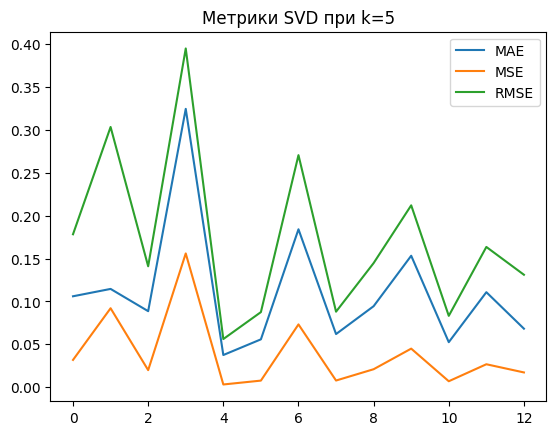

In [17]:
plot = prec.plot(title=f'Метрики SVD при k={K}')
fig = plot.get_figure()
fig.savefig(f"svdk{K}.png", dpi=300, bbox_inches='tight')